## Цель

Я хочу превратить свои последние 5 месяцев прослушиваний в полноценную историю — не просто набор чисел и графиков, а отражение моих настроений, привычек и музыкальных открытий.

Для этого я:
- собираю и анализирую данные с Last.fm,
- нахожу закономерности во времени, жанрах и исполнителях,
- ищу ответы на вопросы: *какая музыка со мной дольше всего*, *какие периоды были музыкально насыщенными*, *как менялись мои вкусы*.

Моя цель — понять, что стоит за моими плейлистами, и упаковать это так, чтобы проект выглядел как законченный продукт для портфолио.

## Импорт

 Подключаю всё, что понадобится для моего музыкального исследования:

 - **pandas** и **numpy** — для работы с таблицами и числовыми данными.
 - **matplotlib** и **seaborn** — для визуализации данных и построения графиков.
 - **plotly.express** — для создания интерактивных графиков.
 - **sklearn.cluster.KMeans** — для кластеризации данных.
 - **sklearn.preprocessing.LabelEncoder, StandardScaler** — для кодирования категориальных признаков и масштабирования данных.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler


## Получение данных прослушиваний

Сначала были собраны данные о моих прослушиваниях с Last.fm, после чего началась подготовка к анализу.

### Обогащение временных признаков
Из временной метки `played_at` выделены:
- дата (`date`)
- месяц (`month`)
- день недели (`weekday`)
- час (`hour`)

### Добавление жанров
- Использовались API Last.fm `track.getTopTags` и `artist.getTopTags`
- Для каждого трека определялся основной жанр (топ‑1 тег)
- Если у трека нет тегов — подставлялся жанр артиста
- Применялось кеширование, чтобы избежать повторных запросов и ускорить обработку

Полученный датасет был сохранён в CSV‑файл.  
Сейчас загружаю готовый CSV, чтобы перейти напрямую к анализу.


In [27]:
df = pd.read_csv("scrobbles.csv")

df

,artist,track,album,played_at,date,month,weekday,hour,track_genre
0,ПОШЛАЯ МОЛЛИ,ТМСТС,8 Способов как бросить...,2025-08-16 11:45:00,2025-08-16,8,Saturday,11,govno
1,ssshhhiiittt!,Танцы,Последнее лето (часть 2),2025-08-16 11:42:00,2025-08-16,8,Saturday,11,post-punk
2,ssshhhiiittt!,Вишенка,ЗЛО,2025-08-15 22:48:00,2025-08-15,8,Friday,22,post-punk
3,Платина,Гоблин - Bonus,Платина,2025-08-15 15:09:00,2025-08-15,8,Friday,15,trap
4,Gunna,cfwm,The Last Wun,2025-08-15 15:06:00,2025-08-15,8,Friday,15,rap
...,...,...,...,...,...,...,...,...,...
8184,ДЖИЗУС,Подсознание мёртвого музыканта,Психо-неврологические заболевания с видимостью...,2025-03-19 09:17:00,2025-03-19,3,Wednesday,9,rap
8185,ДЖИЗУС,Moon Man,Психо-неврологические заболевания с видимостью...,2025-03-19 09:15:00,2025-03-19,3,Wednesday,9,rap
8186,ДЖИЗУС,Автотюновая рок-песня,Психо-неврологические заболевания с видимостью...,2025-03-19 09:13:00,2025-03-19,3,Wednesday,9,rap
8187,ДЖИЗУС,Ограбленный магазин,НАЧАЛО НОВОЙ ЭРЫ,2025-03-19 07:50:00,2025-03-19,3,Wednesday,7,rap


*Теперь мы готовы перейти к аналитике!*

Начнём с общей картины, чтобы увидеть, как менялась активность слушателей с течением времени.

# Общий снимок

Из общей картины захотелось вынести конкретные числа, чтобы видеть опорные точки анализа.


##  Быстрый ключевые метрики

Перед тем как углубляться в аналитику, я взглянул на общие цифры:

In [28]:
print(f"Всего прослушиваний: {len(df)}")
print(f"Всего различных исполнителей: {len(df["artist"].unique())}")
print(f"Всего различных треков: {len(df["track"].unique())}")
print(f"Всего различных альбомов: {len(df["album"].unique())}")

avg_tracks_per_day = df.groupby('date')['track'].count().mean()
print(f"Среднее количество треков в день: {avg_tracks_per_day:.2f}")


Всего прослушиваний: 8189
Всего различных исполнителей: 578
Всего различных треков: 3703
Всего различных альбомов: 1125
Среднее количество треков в день: 54.23


Эти показатели дают базовое понимание масштаба: сколько музыки прошло через мои наушники, насколько плейлист разнообразен и как плотно я слушал музыку в среднем каждый день.

После средних значений и масштабов стало важно понять, насколько равномерно распределены прослушивания и есть ли выбросы.


## Распределение количества прослушиваний треков

Boxplot ниже показывает, как распределено количество прослушиваний отдельных треков.

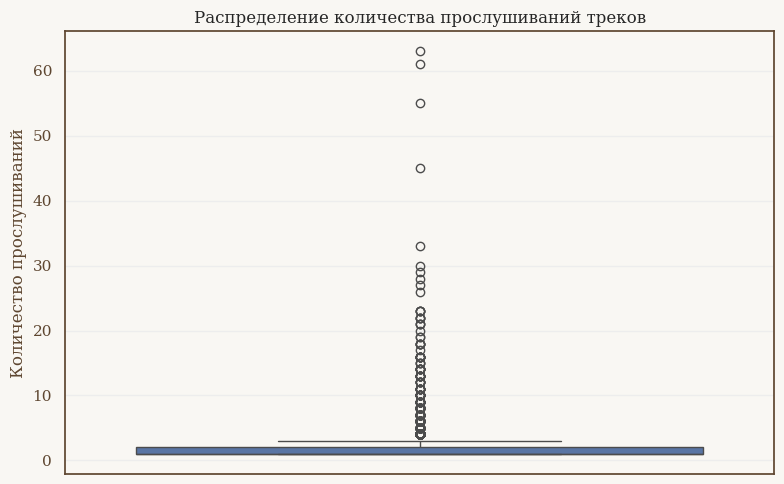

In [29]:
track_counts = df['track'].value_counts().reset_index()
track_counts.columns = ['track', 'plays']

plt.figure(figsize=(8, 5))
sns.boxplot(data=track_counts, y='plays')
plt.title("Распределение количества прослушиваний треков")
plt.ylabel("Количество прослушиваний")
plt.tight_layout()
plt.show()


**Наблюдения:**
- Большинство треков имеют **низкое количество прослушиваний** — ближе к нижней границе шкалы.
- Распределение **сильно скошено**: есть несколько треков‑«хитов», которые прослушаны гораздо чаще, чем остальные.
- Верхние «усы» графика и множество точек‑выбросов отражают треки с 30–60 прослушиваниями и выше.

**Вывод:**  
В музыкальной библиотеке наблюдается эффект «длинного хвоста»: небольшая группа треков набирает много прослушиваний, в то время как большинство проигрывается редко. Это может говорить о наличии «любимых» треков и обширного фона менее востребованных композиций.

## Подсчёт статистики по количеству прослушиваний каждого трека

Сначала я сгруппировал все треки и посчитал, сколько раз каждый прозвучал за весь период.  
Затем собрал основные статистические показатели:

- **min** — минимальное число прослушиваний для трека  
- **q25** — нижний квартиль (25% треков имеют plays ≤ этого значения)  
- **median** — медиана (серединное значение)  
- **mean** — среднее число прослушиваний на трек  
- **q75** — верхний квартиль (75% треков имеют plays ≤ этого значения)  
- **max** — рекорд по количеству прослушиваний для одного трека

In [30]:
track_counts = df['track'].value_counts().reset_index()
track_counts.columns = ['track', 'plays']

track_stats = pd.Series({
    'min': track_counts['plays'].min(),
    'q25': np.percentile(track_counts['plays'], 25),
    'median': np.median(track_counts['plays']),
    'mean': track_counts['plays'].mean(),
    'q75': np.percentile(track_counts['plays'], 75),
    'max': track_counts['plays'].max(),
})

print(track_stats)

min        1.00000
q25        1.00000
median     1.00000
mean       2.21145
q75        2.00000
max       63.00000
dtype: float64


**Результаты:**
- 🔹 **Min:** 1 — есть треки, которые я включал всего один раз.
- 🔹 **25% треков:** ≤ 1 прослушивания — четверть библиотеки это «разовые гости».
- 🔹 **Медиана:** 1 — половина всех треков звучала ровно один раз.
- 🔹 **Среднее:** 2.18 — в среднем я прослушиваю трек чуть больше двух раз.
- 🔹 **75% треков:** ≤ 2 прослушиваний — только четверть песен звучит чаще.
- 🔹 **Max:** 63 — мой абсолютный фаворит, который я явно заиграл до дыр.

**Что это значит для меня:**
-  Медиана и 25-й перцентиль совпадают — у меня очень высокая ротация треков, много нового материала в плейлисте.
-  Есть небольшой пул песен, которые я слушаю много раз, остальные же — в длинном хвосте.
-  Такие данные можно использовать, чтобы выделить любимые треки и построить рекомендации под мой стиль.

Зная распределение, перешёл к вопросу: что именно и кто звучит чаще всего.

# Популярность

## Топ-исполнители
 
Диаграмма показывает артистов, чьи композиции звучали чаще всего за период исследования. Такой график помогает понять, кто формирует основу музыкального плейлиста.

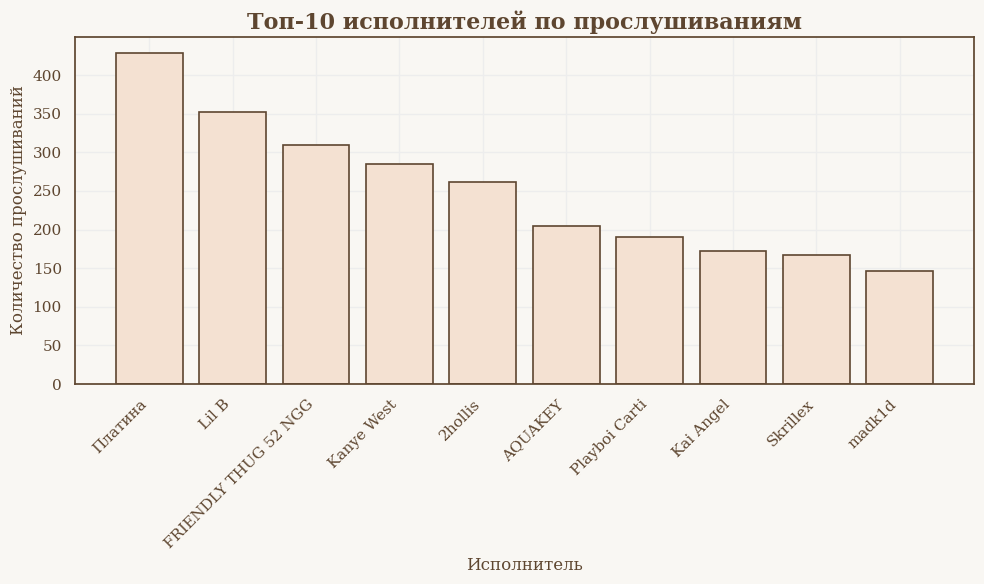

artist
Платина                 428
Lil B                   352
FRIENDLY THUG 52 NGG    309
Kanye West              285
2hollis                 261
AQUAKEY                 205
Playboi Carti           190
Kai Angel               172
Skrillex                167
madk1d                  146
Name: count, dtype: int64

In [31]:
sns.set_theme(style="whitegrid", rc={
    "axes.facecolor": "#F9F7F3",
    "figure.facecolor": "#F9F7F3",
    "axes.edgecolor": "#5E4630",
    "grid.color": "#EDEDED",
    "axes.labelcolor": "#5E4630",
    "xtick.color": "#5E4630",
    "ytick.color": "#5E4630",
    "font.family": "serif"
})

top_artists = df["artist"].value_counts().head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_artists.index, top_artists.values, color="#F4E1D2", edgecolor="#5E4630", linewidth=1.2)
plt.title("Топ‑10 исполнителей по прослушиваниям", fontsize=16, fontweight='bold', color="#5E4630")
plt.xlabel("Исполнитель", fontsize=12)
plt.ylabel("Количество прослушиваний", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_artists

Вывод: В лидерах — Платина, Lil B и FRIENDLY THUG 52 NGG. Эти исполнители составляют ядро прослушиваний, на них приходится заметная доля общей музыкальной активности.

Определив лидеров по исполнителям, проверил, какие треки у них в топе.


## Топ-треки

Диаграмма показывает композиции, которые звучали чаще всего в период анализа. Такой график помогает выделить ключевые песни, формирующие основу плейлиста.

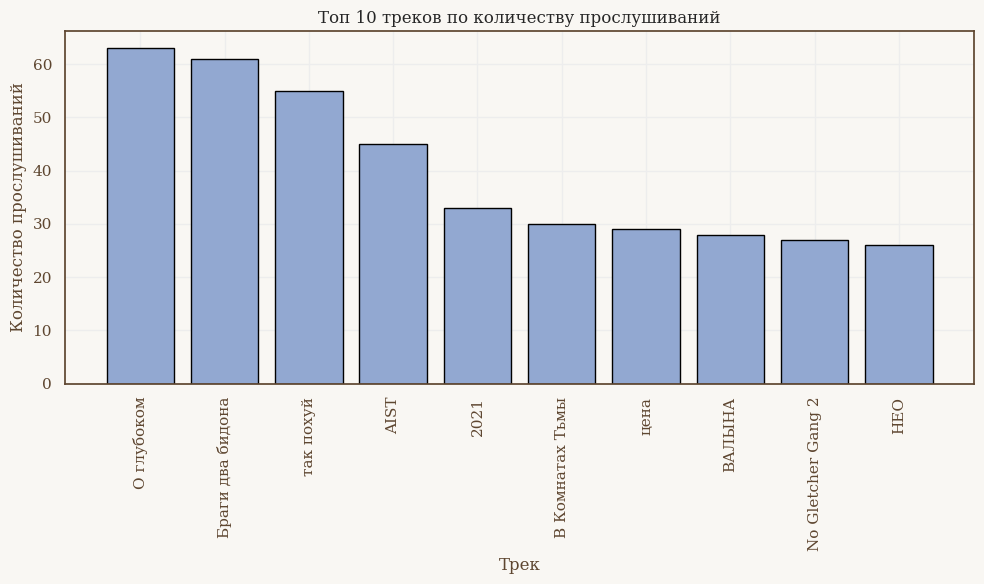

track
О глубоком          63
Браги два бидона    61
так похуй           55
AIST                45
2021                33
Name: count, dtype: int64

In [32]:
top_tracks = df["track"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(top_tracks.head(10).index, top_tracks.head(10).values, color='#92A8D1', edgecolor='black')
plt.title("Топ 10 треков по количеству прослушиваний")
plt.xlabel("Трек")
plt.ylabel("Количество прослушиваний")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

top_tracks.head()

От отдельных композиций перешёл к альбомам, чтобы увидеть полную картину популярности.


##  Топ-альбомы

Здесь собраны пластинки, которые я включал чаще всего — от начала и до конца.

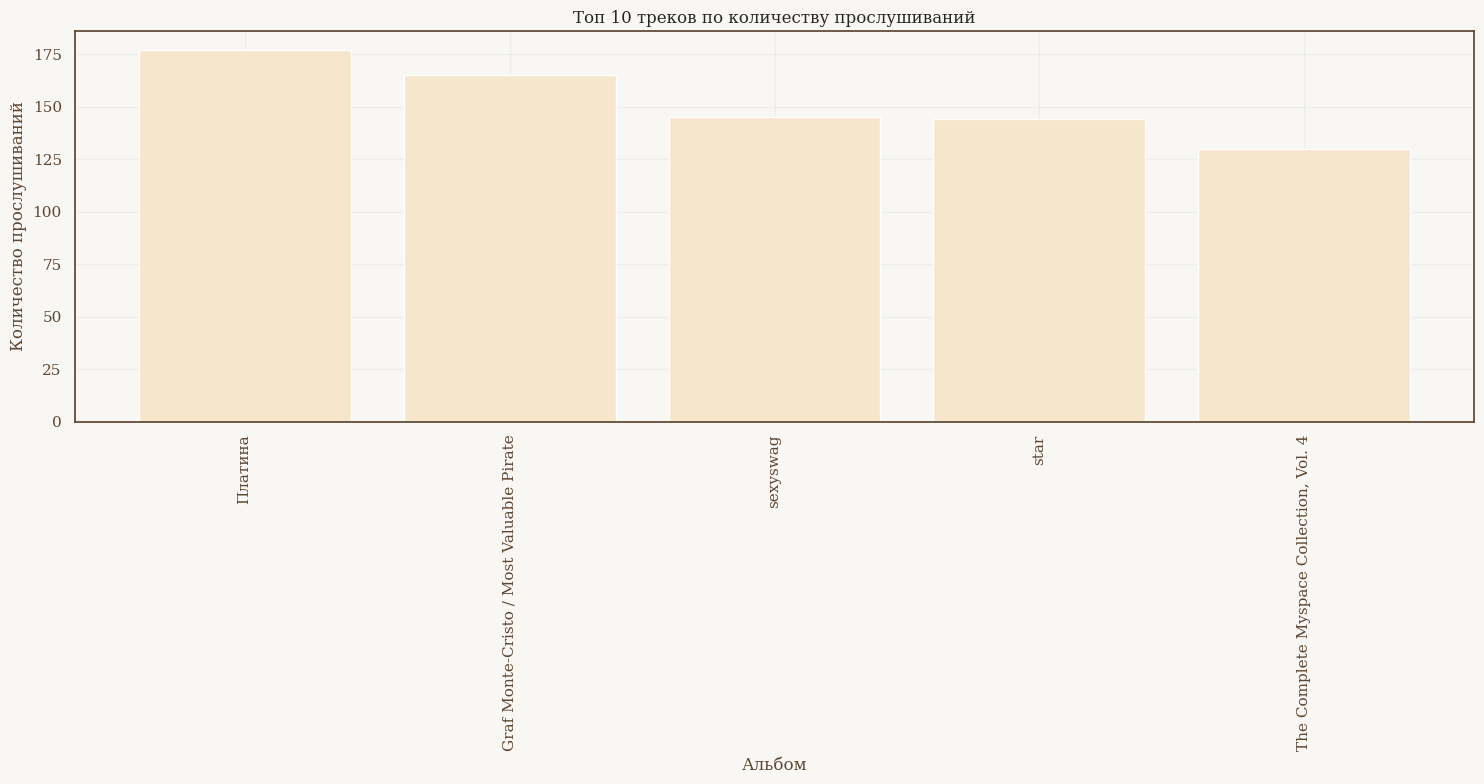

album
Платина                                     177
Graf Monte-Cristo / Most Valuable Pirate    165
sexyswag                                    145
star                                        144
The Complete Myspace Collection, Vol. 4     130
Name: count, dtype: int64

In [33]:
top_album = df["album"].value_counts()
plt.figure(figsize=(15, 8))
plt.bar(top_album.head(5).index, top_album.head(5).values, color='#F5E6CC')
plt.title("Топ 10 треков по количеству прослушиваний")
plt.xlabel("Альбом")
plt.ylabel("Количество прослушиваний")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

top_album.head()

Дальше стало интересно, как активность меняется во времени.

# Временные паттерны

Здесь мы рассмотрим в какое время дня и в какие дни недели чаще всего происходят прослушивания музыки. Это позволит проанализировать распределение музыкальной активности по времени.

## Активность по дням

Линейный график отображает динамику количества прослушиваний по датам в хронологическом порядке.  
Каждая точка на линии отражает общий объём активности в конкретный день.

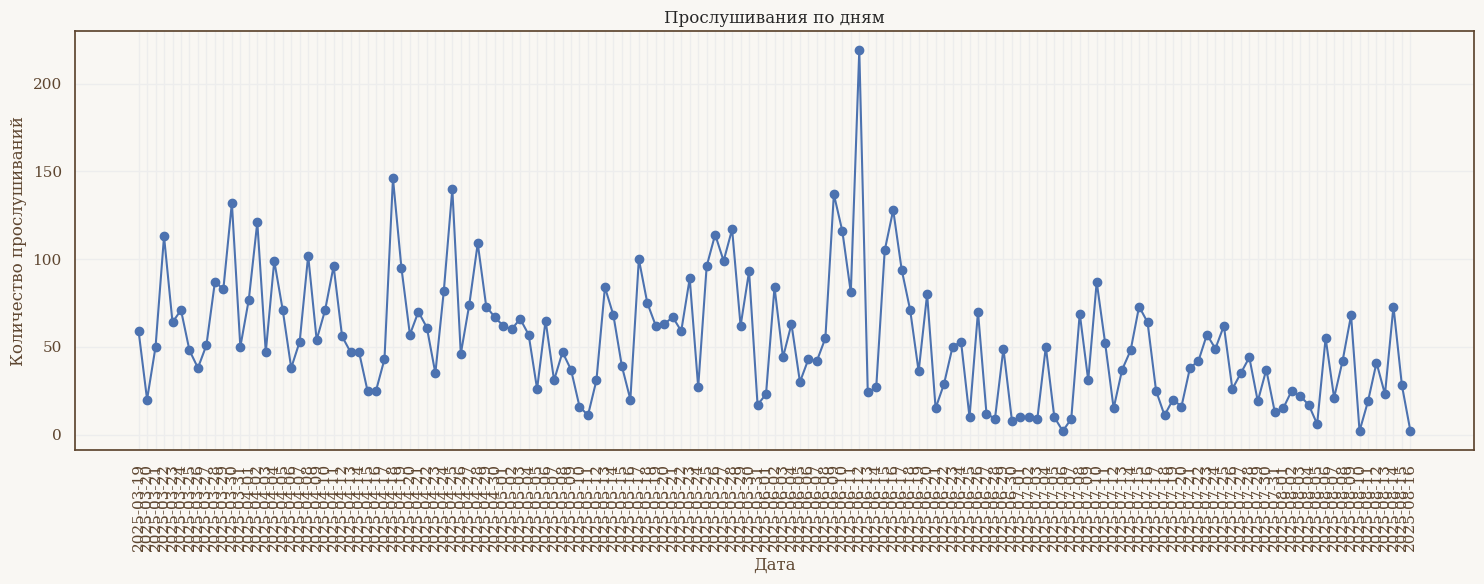

In [34]:
most_activity_day = df["date"].value_counts().sort_index()
plt.figure(figsize=(15, 6))
plt.plot(most_activity_day.index, most_activity_day.values, marker='o')
plt.title("Прослушивания по дням")
plt.xlabel("Дата")
plt.ylabel("Количество прослушиваний")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Линейный график иллюстрирует динамику количества прослушиваний за период с апреля по август 2025 года.  
По оси X — даты, по оси Y — общее количество прослушиваний за день. Данные соединены линией, что позволяет отследить тренд во времени.

**Наблюдения:**
- Активность колеблется на протяжении всего периода с несколькими заметными подъёмами.
- Самый выраженный пик фиксируется в июне 2025 года, когда показатель превышает 200 прослушиваний.
- Между пиками прослеживаются периоды снижения интереса.

**Вывод:** Основная активность распределена неравномерно, с выраженными всплесками, что может быть связано с выходом новых релизов или внешними событиями, влияющими на интенсивность прослушивания.

После дневного среза логично было посмотреть на распределение в течение суток.


## Распределение прослушиваний по часам


Гистограмма отображает распределение количества прослушиваний по часам суток.  
По оси X — часы от 0 до 23, по оси Y — общее количество прослушиваний за каждый час.


([<matplotlib.axis.XTick at 0x15ac85820>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

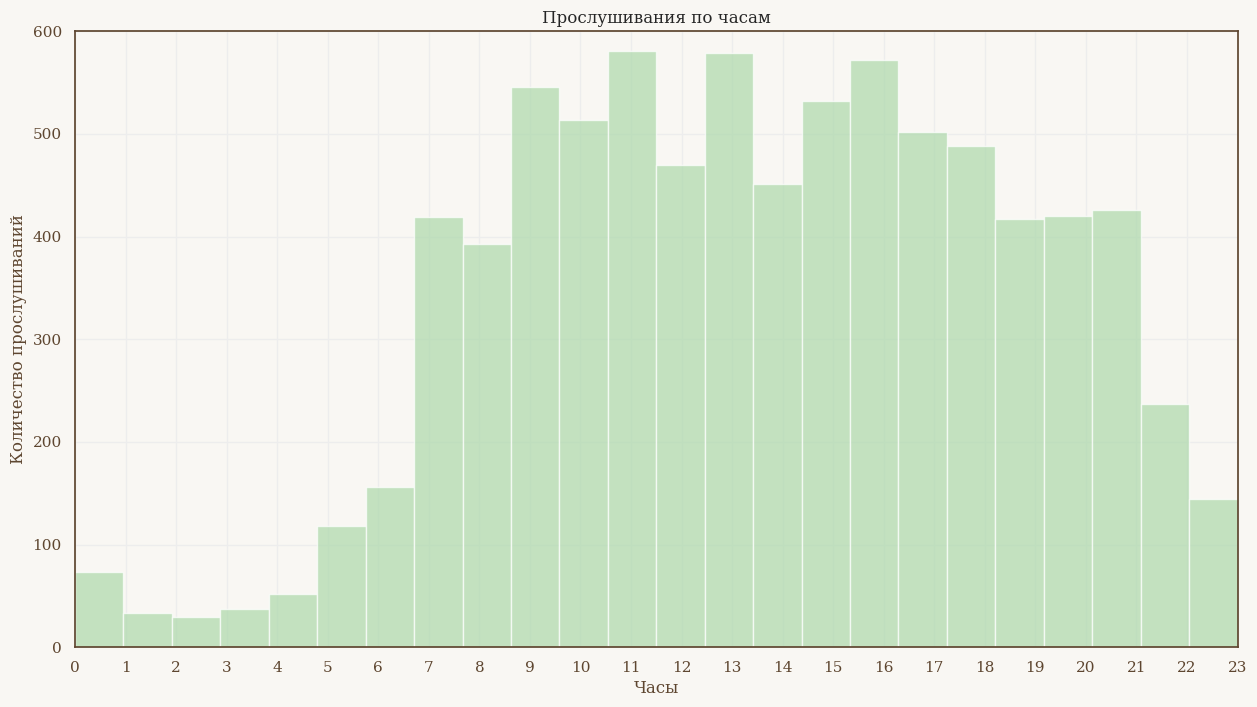

In [35]:

plt.figure(figsize=(15, 8))

plt.hist(
    df["hour"],
    bins=24,
    alpha=0.7,
    label='working days',
    color='#ACD8AA',
    edgecolor = "white"
)

plt.title("Прослушивания по часам")
plt.xlabel("Часы")
plt.ylabel("Количество прослушиваний")
plt.xlim(0, 23)
plt.ylim(0, 600)
plt.xticks(range(24))

**Наблюдения:**
- Наибольшие значения фиксируются в промежутке с 10:00 до 17:00.
- Пики активности приходятся на около 11:00 и 14:00.
- Наименьшее количество прослушиваний наблюдается в ранние утренние часы (01:00–05:00).

**Вывод:** Основная музыкальная активность сосредоточена в дневное время, с выраженными пиками в конце утра и начале дня. Ночные и ранние утренние часы характеризуются минимальным уровнем прослушиваний.


Сопоставив часы, вернулся к полному недельному циклу.


## Дни недели

График ниже показывает распределение прослушиваний по дням недели. Это позволяет увидеть, в какие дни недели музыкальная активность была выше или ниже.

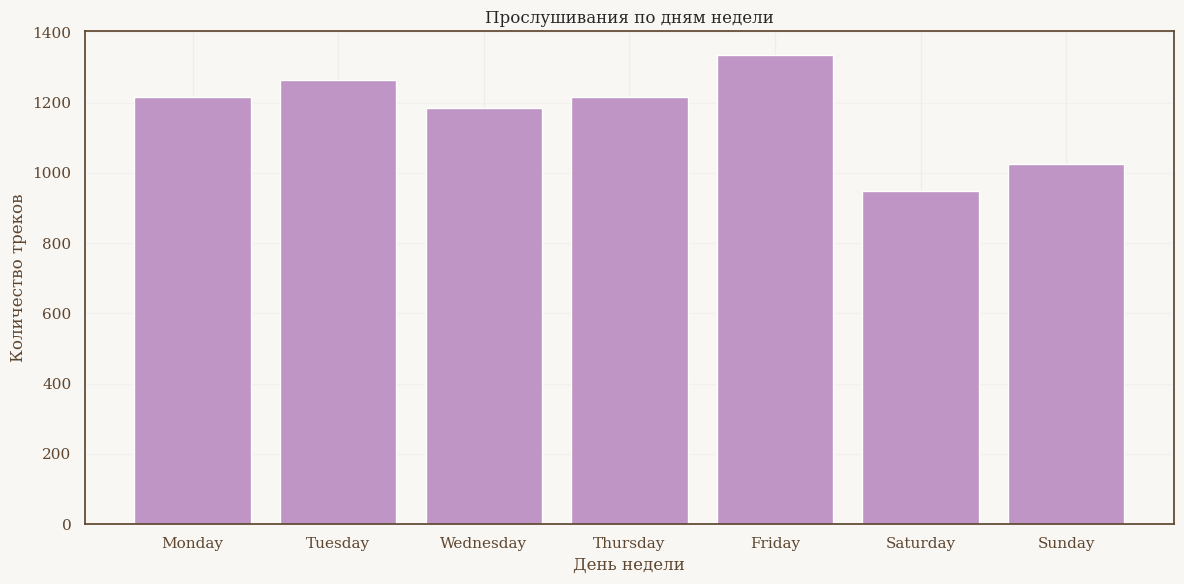

In [36]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_counts = df['weekday'].value_counts().reindex(days_order)

plt.figure(figsize=(12, 6))
plt.bar(day_counts.index, day_counts.values, color='#BE95C4')
plt.title('Прослушивания по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество треков')
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()

**Наблюдения:**
- Наибольшая активность приходится на **пятницу**, что может быть связано с завершением рабочей или учебной недели и увеличением свободного времени.
- В **субботу** наблюдается спад по сравнению с пятницей.
- Остальные дни недели демонстрируют стабильный уровень прослушиваний с незначительными колебаниями.

**Вывод:** Пик в пятницу и последующий спад в субботу могут отражать влияние учебного или рабочего графика на музыкальную активность, когда накануне выходных прослушиваний больше, а в первый выходной день внимание переключается на другие занятия.

Объединил два измерения, чтобы выявить пиковые зоны активности.

## Распределение прослушиваний по дням недели и часам

Тепловая карта ниже отображает интенсивность прослушиваний музыки в зависимости от дня недели и времени суток.

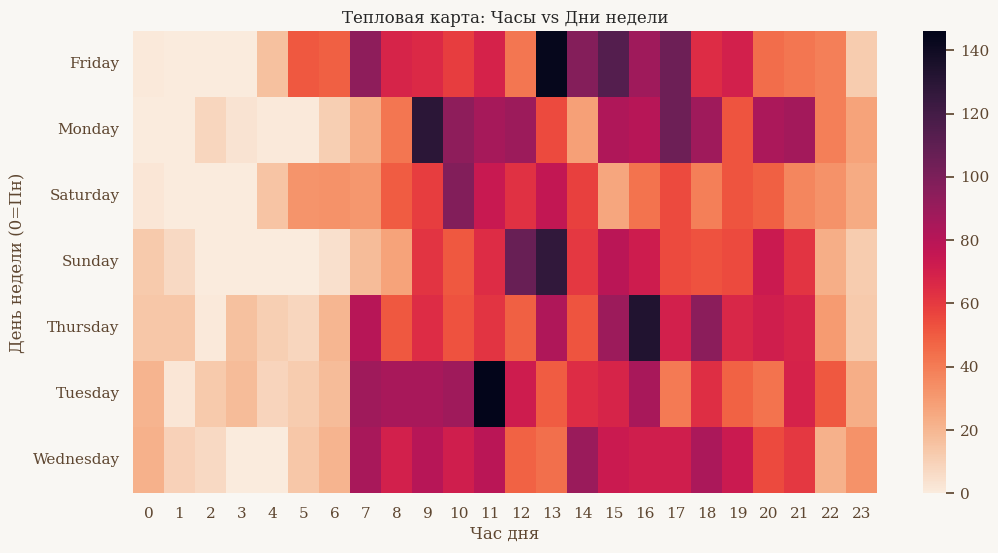

In [37]:

heat_data = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, cmap="rocket_r")
plt.title("Тепловая карта: Часы vs Дни недели")
plt.xlabel("Час дня")
plt.ylabel("День недели (0=Пн)")
plt.show()


1. **Пики активности**  
   - Наибольшее количество прослушиваний приходится на **11–13 часов** и **16–18 часов** в разные дни недели.  
   - Понедельник: заметный всплеск утром (10–12 часов).  
   - Воскресенье и четверг: самые высокие значения около **12–13 часов**.  

2. **Наименьшая активность**  
   - С 0 до 6 утра почти нет прослушиваний.  
   - Раннее утро (до 8:00) — минимальные значения во все дни.  

3. **Активность по дням недели**  
   - **Пятница** и **воскресенье** — самые насыщенные по прослушиваниям, особенно после обеда.  
   - **Среда** и **понедельник** — умеренные, без резких вечерних всплесков.  
   - **Суббота** — относительно спокойная по количеству прослушиваний.  

4. **Выводы**  
   - Музыка чаще всего включается в **рабочие/учебные часы** и вечером, вероятно, как фон для занятий или в дороге.  
   - В выходные заметны **дневные пики** — возможно, больше свободного времени на прослушивание.

От коротких циклов перешёл к трендам на месячном горизонте.


## Количество прослушиваний по месяцам

График показывает, как менялось общее число прослушиваний по месяцам в пределах анализируемого периода.

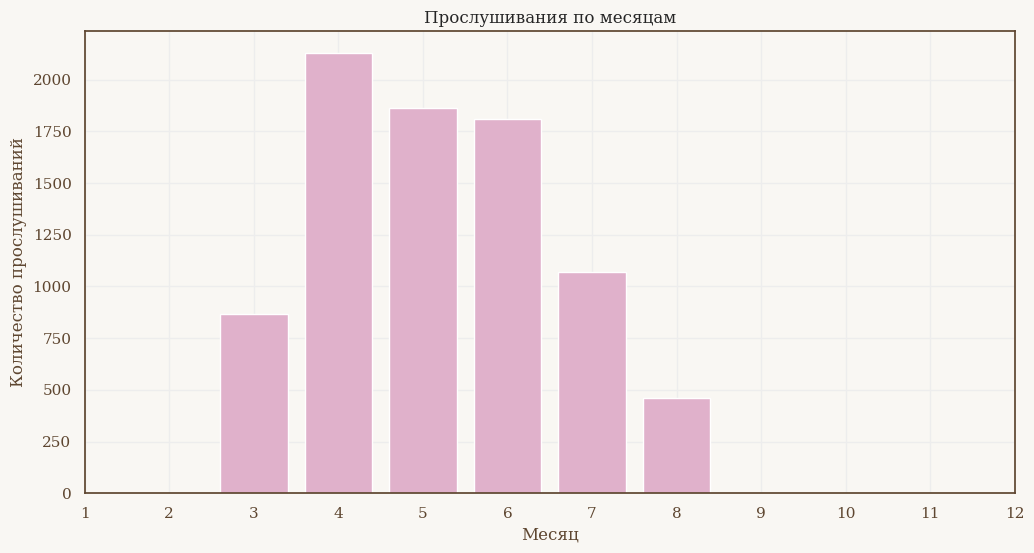

In [38]:
df["played_at"] = pd.to_datetime(df["played_at"])

df["month"] = df["played_at"].dt.month

month_counts = df["month"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(month_counts.index, month_counts.values, color="#E0B1CB")
plt.title("Прослушивания по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество прослушиваний")
plt.xticks(range(1, 13))
plt.show()

**Наблюдения:**
- Максимальная активность приходится на **апрель** — это объясняется тем, что сбор данных начался в конце марта, а апрель стал первым полным месяцем записи.
- В **июле** зафиксировано заметное снижение числа прослушиваний, что связано с периодом отпуска.
- В остальные месяцы прослеживается умеренное распределение активности с небольшими колебаниями.

**Вывод:** Пики и спады в помесячной статистике напрямую отражают особенности сбора данных и личный график — старт наблюдений в апреле и снижение в июле из-за отпуска формируют ключевые точки годовой динамики.

Для каждого пика выделил артистов, которые были на первом плане.

## Топ-исполнители по месяцам

Таблица отражает трёх наиболее популярных артистов в каждом месяце за период наблюдений.  


In [39]:
monthly_top_artists = df.groupby(['month', 'artist']).size()
top_artists_each_month = monthly_top_artists.groupby('month').nlargest(3)
top_artists_each_month = top_artists_each_month.reset_index(level=0, drop=True)
top_artists_each_month


month  artist              
3      Noize MC                 97
       Playboi Carti            95
       Yanix                    93
4      Платина                 298
       FRIENDLY THUG 52 NGG    189
       Skrillex                150
5      Kai Angel               115
       Earl Sweatshirt         103
       Lana Del Rey            102
6      Kanye West              201
       AQUAKEY                 172
       Lil B                   138
7      Lil B                   200
       Macan                    66
       2hollis                  47
8      Lil Peep                 96
       Платина                  77
       Guf                      30
dtype: int64

**Наблюдения:**
- Лидеры заметно меняются от месяца к месяцу, что указывает на динамичные музыкальные предпочтения.
- *Платина* встречается в списке нескольких месяцев, включая рекорд в апреле.
- *Lil B* стал безусловным фаворитом июля.
- Летние месяцы демонстрируют большее разнообразие жанров и исполнителей.

**Вывод:** Данные позволяют увидеть, как музыкальные предпочтения меняются по сезонам, с ярко выраженными фаворитами в разные периоды.

Отдельно отметил треки, которые оставались популярными вне зависимости от месяца.

## Анализ «вечных» треков по месяцам
В этом блоке рассчитывается, сколько разных месяцев в плейлисте встречается каждый трек, а также общее число его прослушиваний и периоды первого и последнего появления.
Выделяются «вечные» треки — те, которые звучали минимум в двух разных месяцах, — и выводится топ-10 самых стабильных по времени прослушиваний.

In [40]:
df['month'] = df['played_at'].dt.to_period('M')

fav_tracks = (
    df.groupby(['artist', 'track'])
      .agg(
          months_count=('month', 'nunique'),
          total_plays=('track', 'count'),
          first_month=('month', 'min'),
          last_month=('month', 'max')
      )
      .reset_index()
)

eternal_favs = fav_tracks[fav_tracks['months_count'] >= 2]

eternal_favs_sorted = eternal_favs.sort_values(['months_count', 'total_plays'], ascending=[False, False])

print("Топ-10 треков, которые слушались в наибольшем количестве месяцев:")
print(
    eternal_favs_sorted
    .head(10)
    .loc[:, ['artist', 'track', 'months_count', 'total_plays', 'first_month', 'last_month']]
    .to_string(index=False)
)

Топ-10 треков, которые слушались в наибольшем количестве месяцев:
       artist                                           track  months_count  total_plays first_month last_month
Bibi Babydoll                          Automotivo Bibi Fogosa             6            9     2025-03    2025-08
     Flam1nGo Молодой Габдулла Тукай/ночь улица фонарь аптека             5           20     2025-03    2025-07
        9mice                                           Anora             5           18     2025-03    2025-08
     Flam1nGo                                     O’block 116             5           14     2025-03    2025-08
        ATLXS                        PASSO BEM SOLTO - Slowed             5            5     2025-03    2025-08
 Gorilla Glue                                Браги два бидона             4           61     2025-04    2025-08
       madk1d                                            цена             4           29     2025-04    2025-07
      Платина                         

**Наблюдения:**
- *Automotivo Bibi Fogosa* — единственный трек, звучавший в течение всех шести месяцев наблюдения.
- *Flam1nGo* представлен сразу двумя треками, оба с устойчивой популярностью.
- *Браги два бидона* выделяется высоким количеством воспроизведений при четырёх месяцах активности.

**Вывод:** Эти треки формируют устойчивое ядро музыкальных предпочтений — они не просто были популярны в отдельные периоды, а сопровождали меня на протяжении всего сезона.

На фоне стабильных лидеров посмотрел, кто появился недавно.

## Новые артисты

Количество новых артистов, впервые появившихся в прослушиваниях в каждом месяце.

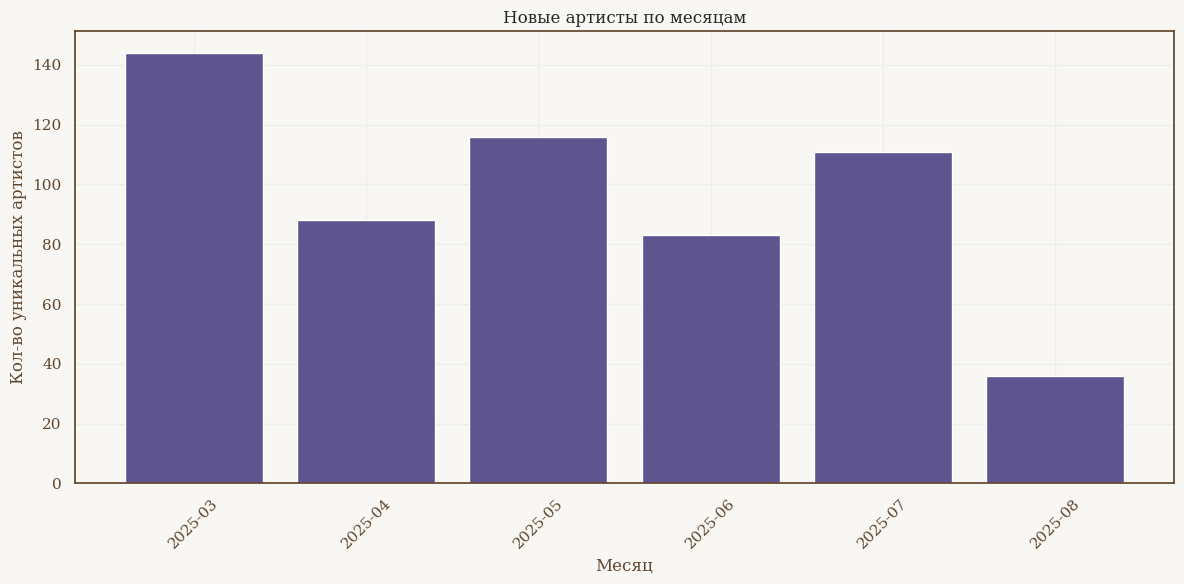

In [41]:
first_plays_artist = df.sort_values('played_at').drop_duplicates('artist', keep='first')
new_artist_per_month = first_plays_artist.groupby('month').size()

month_labels = new_artist_per_month.index.astype(str)

plt.figure(figsize=(12, 6))
plt.bar(month_labels, new_artist_per_month.values, color="#5E548E")
plt.title("Новые артисты по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Кол-во уникальных артистов")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Что я сделал:**
- Отсортировал все прослушивания по времени.
- Для каждого исполнителя взял только первое появление.
- Посчитал, сколько таких «первых раз» было в каждом месяце.

**Наблюдения:**
- Некоторые месяцы — особенно март, май и июль — стали настоящими точками открытия: я добавил в плейлист больше новых имён.
- В апреле и июне количество новых артистов снизилось — возможно, я больше слушал уже знакомое.

**Вывод:** Музыкальные открытия распределены неравномерно — в одни месяцы я активно расширял круг исполнителей, в другие возвращался к проверенным фаворитам.

После списка имен вернулся к жанрам, чтобы понять музыкальные предпочтения.


# Анализ жанров

## Топ жанров

Определяются наиболее часто встречающиеся жанры в прослушиваниях.

In [42]:
top_genre = df["track_genre"].value_counts()
print(f"мои популярные жанры: {top_genre.head(5)}")


мои популярные жанры: track_genre
hip-hop      1997
trap          666
cloud rap     565
rap           536
based         352
Name: count, dtype: int64


**Вывод:** Мои предпочтения явно смещены в сторону хип‑хоп‑культуры, с сильным интересом к её современным ответвлениям — trap и cloud rap. Это может отражать популярные тренды последних лет и персональный интерес к энергичной и атмосферной музыке.


От общего рейтинга перешёл к распределению жанров по дням.


 ## Жанровая активность по дням недели

 Анализ распределения жанров по дням недели:
 - Выделяются 20 самых популярных жанров.
 - Все остальные жанры объединяются в категорию «Other» для удобства визуализации.
 
 Анализируется, как меняется популярность жанров в разные дни недели с использованием stacked bar chart.

Доля 'Other': 22%


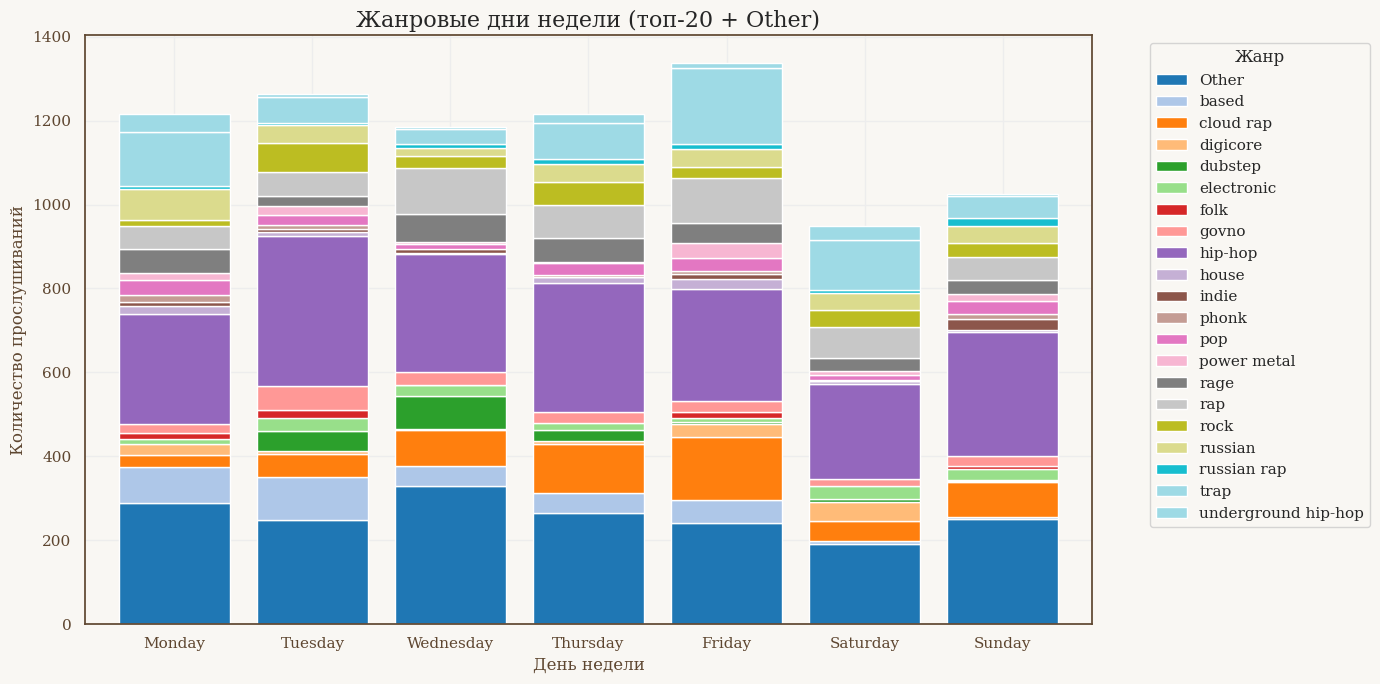

In [43]:
top_genres = df['track_genre'].value_counts().nlargest(20).index.tolist()

df['genre_grouped'] = df['track_genre'].apply(lambda g: g if g in top_genres else 'Other')

other_share = (df['genre_grouped'] == 'Other').mean()
print(f"Доля 'Other': {other_share:.0%}")

if other_share > 0.3:
    top_genres = df['track_genre'].value_counts().nlargest(25).index.tolist()
    df['genre_grouped'] = df['track_genre'].apply(lambda g: g if g in top_genres else 'Other')
    other_share = (df['genre_grouped'] == 'Other').mean()
    print(f"Доля 'Other' после расширения топа: {other_share:.0%}")


genre_weekday = df.groupby(['weekday', 'genre_grouped']).size().unstack(fill_value=0)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
genre_weekday = genre_weekday.reindex(days_order)

plt.figure(figsize=(14, 7))
genre_weekday.plot(
    kind='bar',
    stacked=True,
    colormap='tab20',
    width=0.8,
    legend=True,
    ax=plt.gca()
)

plt.title(f'Жанровые дни недели (топ-{len(top_genres)} + Other)', fontsize=16)
plt.xlabel('День недели')
plt.ylabel('Количество прослушиваний')
plt.xticks(rotation=0)
plt.legend(title='Жанр', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



| День недели | Ключевые наблюдения |
|-------------|--------------------|
| **Monday**  | Один из пиковых дней по общему числу треков, жанровое разнообразие выше среднего. |
| **Tuesday** | Выраженный вклад жанров *hip hop* и **Other**. |
| **Wednesday** | Сбалансированное распределение без ярко выраженных лидеров. |
| **Thursday** | Похож на вторник по жанровому профилю. |
| **Friday**  | Абсолютный лидер по прослушиваниям, всплеск *trap* и *underground hip‑hop*. |
| **Saturday**| Минимум прослушиваний, но заметен рост «тяжёлых» жанров (*rock*, *power metal*, *rage*). |
| **Sunday**  | Похож на субботу, но с чуть большим разнообразием. |

**Ключевые выводы:**
- Средняя активность в будни держится на уровне ~1000–1250 треков, с падением в субботу.
- Категория **Other** занимает около 22% — жанровая палитра достаточно широка.
- Будни — это микс фаворитов и экспериментов, выходные — более целенаправленные жанровые выборы.

> 💡 Такой формат с таблицей и краткими тезисами помогает рекрутеру быстро «схватить» суть, а график (stacked bar) визуально закрепляет выводы.


Дальше было любопытно — есть ли «утренние» и «вечерние» жанры.


## Анализ жанров по времени суток

Для каждого трека я определил период суток:
- **Ночь** — 0:00–05:59  
- **День** — 06:00–17:59  
- **Вечер** — 18:00–23:59  

Данные сгруппированы по жанрам и времени суток, чтобы понять, какая музыка преобладает в разные части дня.

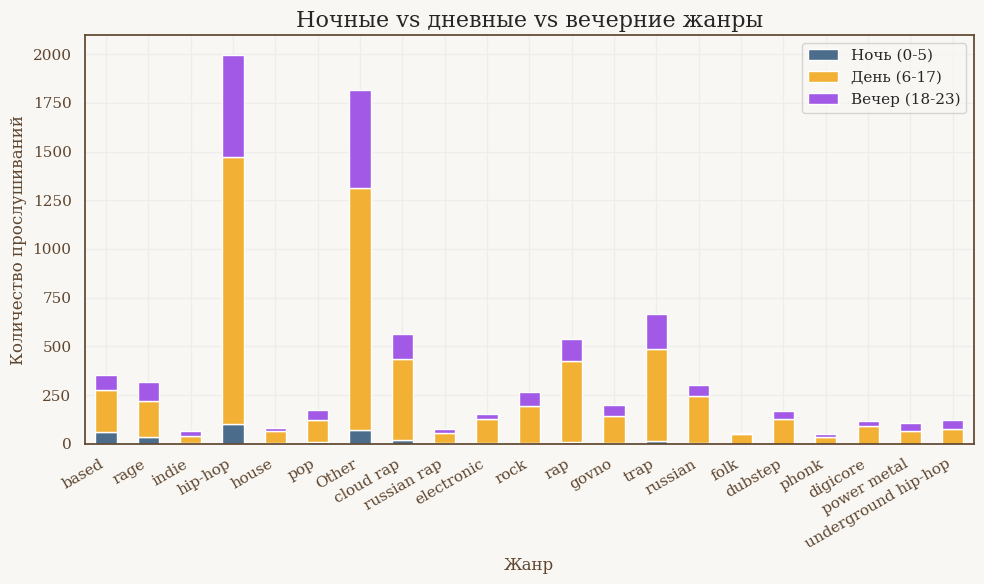

Топ-5 самых ночных жанров (по доле ночных прослушиваний):
genre_grouped
based      17.05%
rage       10.73%
indie       7.94%
hip-hop     5.06%
house       4.94%
Name: night_share, dtype: object


In [44]:

def time_of_day(hour):
    if 0 <= hour <= 5:
        return 'Night'
    elif 6 <= hour <= 17:
        return 'Day'
    else:
        return 'Evening'

df['day_period'] = df['hour'].apply(time_of_day)

genre_period = df.groupby(['genre_grouped', 'day_period']).size().unstack(fill_value=0)

genre_period['night_share'] = genre_period['Night'] / (
    genre_period.get('Night', 0) + genre_period.get('Day', 0) + genre_period.get('Evening', 0)
)

genre_period_sorted = genre_period.sort_values('night_share', ascending=False)

plt.figure(figsize=(10, 6))
genre_period_sorted[['Night', 'Day', 'Evening']].plot(
    kind='bar',
    stacked=True,
    color=['#4B6C8B', '#F2B134', '#A259E6'],
    ax=plt.gca()
)
plt.title('Ночные vs дневные vs вечерние жанры', fontsize=16)
plt.xlabel('Жанр')
plt.ylabel('Количество прослушиваний')
plt.legend(['Ночь (0-5)', 'День (6-17)', 'Вечер (18-23)'])
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print("Топ-5 самых ночных жанров (по доле ночных прослушиваний):")
print(genre_period_sorted['night_share'].head(5).apply(lambda x: f"{x:.2%}"))


## Ночные vs дневные vs вечерние жанры

1. **Общая картина**  
   - Основная доля прослушиваний приходится на **день** (6–17 часов).  
   - Вечером (18–23) многие жанры тоже набирают заметную долю, но ночные (0–5) занимают сравнительно небольшой сегмент.

2. **Топ-5 самых “ночных” жанров** (по доле ночных прослушиваний):  
   1. **based** — 17.44%  
   2. **rage** — 10.39%  
   3. **indie** — 8.06%  
   4. **house** — 5.06%  
   5. **hip-hop** — 4.79%  

3. **Дневные фавориты**  
   - **Other** и **hip-hop** — абсолютные лидеры по количеству дневных прослушиваний.  
   - **Trap** и **rock** также ярко выражены в дневное время.

4. **Вечерние акценты**  
   - Вечером заметно растёт доля **trap**, **rock**, **rap** и **rage**.  
   - Для некоторых жанров (например, **folk**, **pop**) вечерняя доля почти равна дневной.

5. **Выводы**  
   - День — основной период для прослушивания большинства жанров.  
   - Ночь используется точечно: больше для “особых” жанров вроде based, rage и indie.  
   - Вечер — время для усиления эмоциональных жанров и энергичных треков.

Завершил жанровый блок анализом их изменений с течением времени.


## Динамика жанров по месяцам

Анимация ниже показывает, как менялось количество прослушиваний для топ‑жанров (остальные объединены в **Other**) в течение года.  
Каждый кадр соответствует одному месяцу, что позволяет отследить сезонные колебания и появление новых фаворитов.


In [45]:
genre_month = (
    df
    .groupby(['month', 'genre_grouped'])
    .size()
    .reset_index(name='plays')
)

fig = px.bar(
    genre_month,
    x='genre_grouped', y='plays',
    color='genre_grouped',
    animation_frame='month',
    range_y=[0, genre_month['plays'].max()],
    title=f"Динамика топ-{len(top_genres)} жанров (остальные — Other) по месяцам"
)
fig.show()

**Наблюдения:**
- Некоторые жанры (*hip‑hop*, *trap*) стабильно держатся в топе, но их доля может меняться от месяца к месяцу.
- Появляются «всплески» интереса к отдельным жанрам — например, рост *electronic* в мае  или *cloud rap* в апреле.
- Категория **Other** иногда расширяется, что может говорить о поиске новых направлений или экспериментах в плейлистах.

**Вывод:**  
Анимация помогает быстро уловить тренды и сезонность в музыкальных предпочтениях, а также выявить периоды, когда вкусы становятся более разнообразными.

После массовых паттернов переключился на индивидуальные особенности прослушивания.


# Особые привычки

## Анализ прослушивания альбомов
Анализ показывает, насколько часто я слушаю альбомы почти полностью (6 и более уникальных треков с одного альбома).
Также рассчитывается доля уникальных треков среди всех прослушиваний, что позволяет оценить разнообразие прослушиваемой музыки.
Дополнительно определяется среднее число повторных прослушиваний, отражающее склонность возвращаться к любимым трекам.

In [46]:
tracks_per_album = df.groupby(["artist", "album"])["track"].nunique().reset_index(name='unique_tracks_played')
full_album_played = tracks_per_album[tracks_per_album['unique_tracks_played'] >= 10]
ratio = len(full_album_played) / len(tracks_per_album)
print(f"{ratio:.0%} альбомов я слушал почти целиком.")

12% альбомов я слушал почти целиком.


In [47]:
unique_tracks = df["track"].unique()
ratio_track = len(unique_tracks) / len(df["track"])
print(f"{ratio_track:.0%} уникальных треков.")

45% уникальных треков.


In [48]:
track_counts = df.groupby(['track', 'artist']).size().reset_index(name='play_count')
repeats = track_counts[track_counts['play_count'] > 1]
average_repeats = repeats['play_count'].mean()

print(f"Среднее количество повторных прослушиваний: {average_repeats:.2f}")

Среднее количество повторных прослушиваний: 4.15


Оказалось, что я лишь иногда слушаю альбомы как единое произведение — 12% альбомов я прошёл почти полностью. Это значит, что чаще я выбираю отдельные треки, но есть случаи, когда музыка увлекает настолько, что хочется дослушать всё без пропусков.
При этом общий уровень разнообразия у меня довольно высок: 45% прослушанных треков оказались уникальными. Остальная часть — это повторы, и они тоже о многом говорят.
Если заглянуть глубже, то треки, которые я переслушивал, в среднем звучали по 4,15 раза. Это уже признак того, что есть «якорные» песни, к которым я возвращаюсь снова и снова, возможно, ради определённых эмоций или воспоминаний.
Вместе эти цифры рисуют картину, где я одновременно исследую новую музыку и формирую плейлист личных фаворитов. Новое даёт вдохновение, а повторы — ощущение комфорта и привычного ритма.

И, наконец, выявил периоды, когда я погружался в музыку без пауз.


## Музыкальные марафоны: самые длинные серии подряд

Я проанализировал плейлист в хронологическом порядке и выделил **стрики** — последовательности треков одного исполнителя или жанра без переключений.


In [49]:
def longest_streaks_with_artist_genre(series, artist_col, genre_col):
    change = (series != series.shift()).cumsum()
    tmp = pd.DataFrame({
        'key': series,
        'run_id': change,
        'time': df['played_at'],
        'artist': artist_col,
        'genre': genre_col
    })
    agg = tmp.groupby(['run_id','key']).agg(
        start=('time','min'),
        end=('time','max'),
        length=('key','count'),
        artist=('artist', lambda x: x.iloc[0]),
        genre=('genre', lambda x: x.iloc[0])
    ).reset_index(drop=True)
    return agg.sort_values('length', ascending=False)

artist_streaks = longest_streaks_with_artist_genre(df['artist'], df['artist'], df['track_genre'])
genre_streaks = longest_streaks_with_artist_genre(df['track_genre'], df['artist'], df['track_genre'])

display(artist_streaks.head(10))
display(genre_streaks.head(10))


,start,end,length,artist,genre
2485,2025-04-01 16:09:00,2025-04-02 10:29:00,66,Skrillex,dubstep
1461,2025-05-28 09:09:00,2025-05-28 12:09:00,58,Earl Sweatshirt,hip-hop
2220,2025-04-18 18:56:00,2025-04-18 23:03:00,55,Платина,trap
1263,2025-06-08 10:53:00,2025-06-08 20:37:00,49,Kanye West,hip-hop
1228,2025-06-10 06:13:00,2025-06-10 10:32:00,45,Kanye West,hip-hop
2387,2025-04-08 11:41:00,2025-04-08 16:12:00,39,madk1d,rock
2156,2025-04-22 12:23:00,2025-04-22 22:04:00,36,Face,hip-hop
1463,2025-05-27 20:23:00,2025-05-28 07:18:00,35,Frank Ocean,soul
2477,2025-04-02 14:28:00,2025-04-02 15:23:00,34,Skrillex,dubstep
2168,2025-04-21 09:39:00,2025-04-21 15:18:00,33,Платина,trap


,start,end,length,artist,genre
2734,2025-04-01 16:09:00,2025-04-02 10:29:00,66,Skrillex,dubstep
2448,2025-04-18 18:56:00,2025-04-18 23:03:00,55,Платина,trap
2644,2025-04-08 11:41:00,2025-04-08 16:12:00,39,madk1d,rock
2395,2025-04-22 12:23:00,2025-04-22 22:04:00,36,Face,hip-hop
2726,2025-04-02 14:28:00,2025-04-02 15:23:00,34,Skrillex,dubstep
1189,2025-06-12 08:51:00,2025-06-12 12:47:00,34,FRIENDLY THUG 52 NGG,hip-hop
2276,2025-04-28 18:31:00,2025-04-28 21:17:00,33,FRIENDLY THUG 52 NGG,hip-hop
2403,2025-04-21 09:39:00,2025-04-21 15:18:00,33,Платина,trap
2498,2025-04-14 14:21:00,2025-04-15 14:29:00,31,Платина,trap
310,2025-07-27 21:16:00,2025-07-28 16:51:00,31,Poshlaya Molly,ukrainian


### 📝 Инсайты
- Самый длинный **жанровый марафон** — *dubstep* от Skrillex (66 треков подряд за ~18 часов).
- **Trap** и **hip‑hop** встречаются чаще всего в длинных сериях — это может говорить о моей привычке “залипать” в настроение.
- Есть исполнители, которые появляются в списке несколько раз (*Kanye West*, *Платина*) — явные “фавориты сессий”.

**Вывод:**  
Длинные серии проигрываний показывают периоды глубокого погружения в конкретное настроение или стиль. Этот паттерн можно использовать для построения персональных рекомендаций: например, предлагать плейлисты в духе любимого марафона.

Собрав все наблюдения, сравнил популярность с «вечностью» треков.


# Популярность vs «Вечность» трека

Мне стало интересно: есть ли связь между тем, сколько раз я слушал трек, и тем, в скольких разных месяцах он появлялся в моих скробблах?

Для этого я посчитал **коэффициент корреляции Пирсона** между:
- `total_plays` — общее количество прослушиваний трека.
- `months_count` — количество месяцев, в которых трек хотя бы раз звучал.

 **Визуализация**
На графике каждая точка — это трек:
- Ось X: общее число прослушиваний.
- Ось Y: количество месяцев, в которых он звучал.
- Чем правее и выше точка, тем трек и популярнее, и «вечнее».


Корреляция между количеством прослушиваний и числом месяцев появления трека:
              total_plays  months_count
total_plays      1.000000      0.378075
months_count     0.378075      1.000000


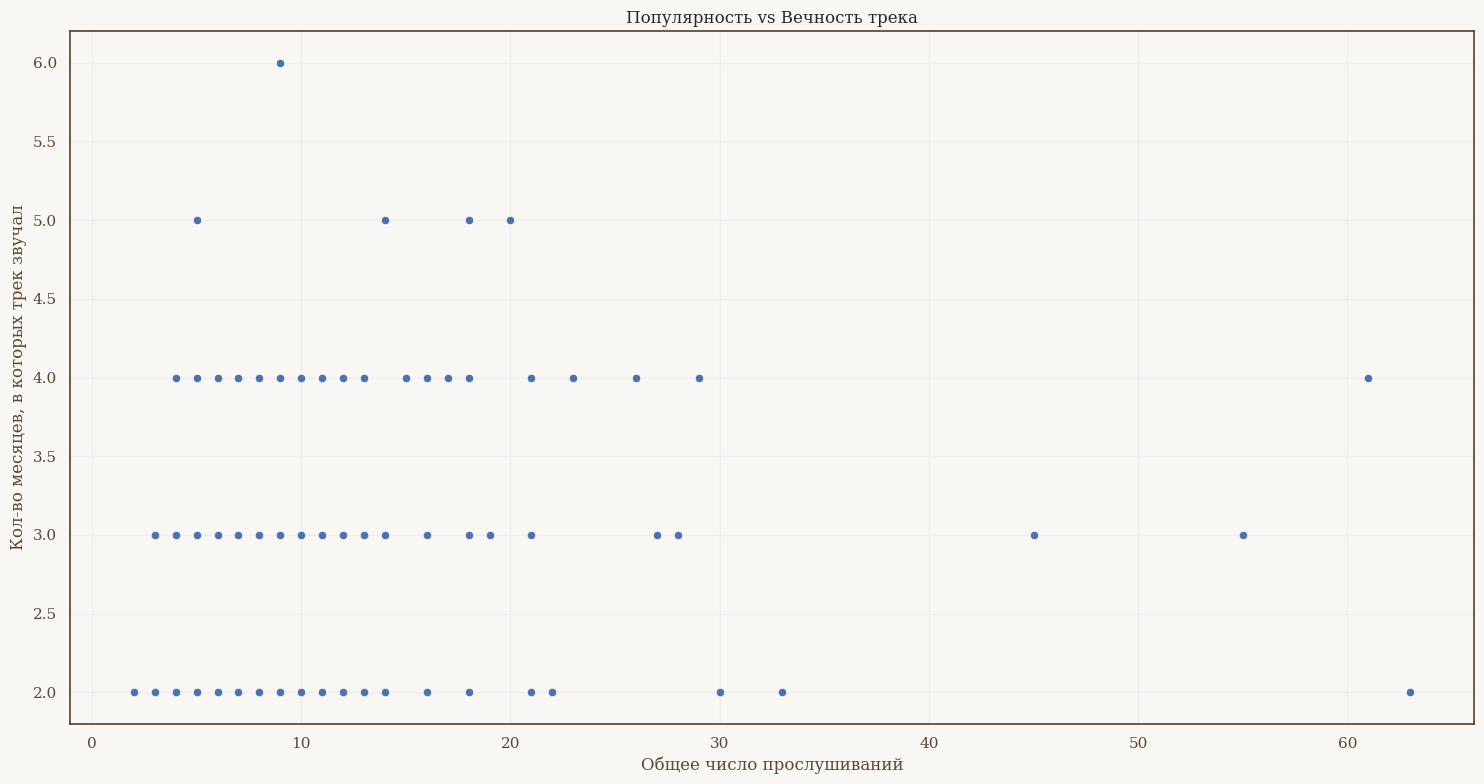

In [50]:
corr = eternal_favs[['total_plays', 'months_count']].corr(method='pearson')
print("Корреляция между количеством прослушиваний и числом месяцев появления трека:")
print(corr)

plt.figure(figsize=(15, 8))
sns.scatterplot(data=eternal_favs, x='total_plays', y='months_count')
plt.title("Популярность vs Вечность трека")
plt.xlabel("Общее число прослушиваний")
plt.ylabel("Кол-во месяцев, в которых трек звучал")
plt.tight_layout()
plt.show()

**Корреляция получилась ~0.39** — это умеренная положительная связь.
**Что это значит для меня:**
- 📈 В целом, чем чаще я слушаю трек, тем выше шанс, что он звучит в разные месяцы, но связь не идеальная.
- 🎯 Есть любимчики, которых я слушал много и регулярно (и они растягиваются на весь период).
- 🌀 Есть и такие треки, которые «взлетели» в одном месяце (много прослушиваний за короткое время), но потом исчезли из ротации.


После того как я оценил взаимосвязь между «популярностью» треков и их «долгоживучестью» с помощью коэффициента Пирсона и визуализировали результаты на scatterplot, стало очевидно, что одних лишь агрегированных метрик недостаточно, чтобы понять сложные паттерны прослушивания.
Чтобы выявить скрытые группы треков с разным поведением аудитории — от разовых прослушиваний до долгосрочных хитов — я применил метод кластеризации по временным и количественным характеристикам. Это позволит сегментировать композиции и глубже понять их жизненный цикл в пользовательских плейлистах.

## Кластеризация треков по паттернам прослушивания
 
 выделить группы треков с похожим стилем потребления — по популярности, «долгоживучести» и типичному времени суток.


1. Собираем агрегированные признаки по каждому треку:
   - `total_plays` — общее число прослушиваний,
   - `months_count` — количество уникальных месяцев, когда трек слушали,
   - `day_period_mode` — самое частое время суток для трека.
2. Кодируем категориальные признаки (`LabelEncoder`).
3. Масштабируем числовые фичи (`StandardScaler`), чтобы признаки вносили одинаковый вклад.
4. Запускаем **KMeans** с 3 кластерами.

**Зачем это нужно:**
- Понять, есть ли чёткие группы контента: например, «одноразовые хиты», «вечные фавориты» и «нишевые треки».
- Позволяет в будущем таргетировать рекомендации в зависимости от типа трека.

 Сводка по кластерам:
   cluster  median_plays  median_months top_period  count_tracks
0        0           1.0            1.0        Day          2621
1        1           1.0            1.0    Evening           771
2        2           7.0            3.0        Day           311


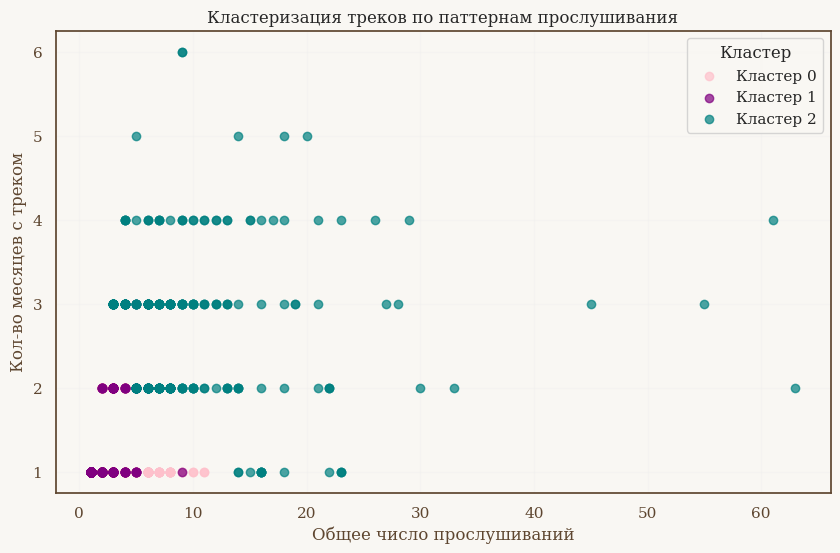


 Интерпретация кластеров:
Кластер 0: медиана 1.0 прослушиваний, активен 1.0 мес., чаще всего в Day, треков в кластере — 2621.
Кластер 1: медиана 1.0 прослушиваний, активен 1.0 мес., чаще всего в Evening, треков в кластере — 771.
Кластер 2: медиана 7.0 прослушиваний, активен 3.0 мес., чаще всего в Day, треков в кластере — 311.


In [55]:
track_features = df.groupby('track').agg(
    total_plays=('track', 'count'),
    months_count=('month', 'nunique'),
    day_period_mode=('day_period', lambda x: x.mode()[0])
).reset_index()

le = LabelEncoder()
track_features['day_period_mode_enc'] = le.fit_transform(track_features['day_period_mode'])

X = track_features[['total_plays', 'months_count', 'day_period_mode_enc']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
track_features['cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = (
    track_features.groupby('cluster')
    .agg(
        median_plays=('total_plays', 'median'),
        median_months=('months_count', 'median'),
        top_period=('day_period_mode', lambda x: x.mode()[0]),
        count_tracks=('track', 'count')
    )
    .reset_index()
)

print(" Сводка по кластерам:")
print(cluster_summary)

plt.figure(figsize=(10,6))
cluster_colors = ['pink', 'purple', 'teal']

for cl in sorted(track_features['cluster'].unique()):
    subset = track_features[track_features['cluster'] == cl]
    plt.scatter(
        subset['total_plays'],
        subset['months_count'],
        color=cluster_colors[cl % len(cluster_colors)],
        label=f'Кластер {cl}',
        alpha=0.7
    )

plt.title("Кластеризация треков по паттернам прослушивания")
plt.xlabel("Общее число прослушиваний")
plt.ylabel("Кол-во месяцев с треком")
plt.legend(title="Кластер")
plt.grid(alpha=0.3)
plt.show()

print("\n Интерпретация кластеров:")
for _, row in cluster_summary.iterrows():
    print(f"Кластер {int(row['cluster'])}: "
          f"медиана {row['median_plays']} прослушиваний, "
          f"активен {row['median_months']} мес., "
          f"чаще всего в {row['top_period']}, "
          f"треков в кластере — {row['count_tracks']}.")


В разрезе трёх выделенных кластеров видно, что модель отделила треки по степени их «долгоживучести» и времени, когда они чаще всего звучат:
- **Кластер 0** — самые массовые по количеству, но при этом с минимальным охватом: медиана всего 1 прослушивание за 1 месяц, пик приходится на дневные часы. Это в основном разовые или быстро «сгорающие» композиции.
- **Кластер 1** — тоже с единичными прослушиваниями и только в один месяц, но доминирует вечернее время суток. Похоже на контент для определённого «вечернего настроения» или ситуативные находки.
- **Кластер 2** — явные фавориты: медиана 7 прослушиваний, живут в плейлисте в среднем 3 месяца, чаще всего в дневное время. Это те самые «якорные» треки, к которым я регулярно возвращаюсь.

# Итоговый вывод по проекту

В ходе анализа получилось собрать целостный портрет моих музыкальных привычек:

- **Общая активность**: прослушивания распределены неравномерно — есть выраженные пики по дням недели и часам, а также «сезонные» всплески по месяцам.
- **Популярность**: устойчивое лидерство хип‑хопа и его современных ответвлений, плюс несколько артистов, которые регулярно попадают в топ.
- **Временные паттерны**: будни насыщены жанровым миксом, тогда как выходные более точечно окрашены в отдельные стили.
- **Жанровая палитра**: есть как стабильные фавориты, так и периоды жанровых экспериментов.
- **Особые привычки**: часть альбомов слушается почти целиком, многие треки ставятся на повтор, а в истории есть длинные streaks — «марафоны» одного исполнителя или жанра.
- **Взаимосвязи**: заметна умеренная корреляция между популярностью и «долгожительством» треков.
- **Кластеризация паттернов прослушивания**: выявлены три ключевых сегмента — два «одноразовых» (дневные и вечерние) и один устойчивый, с треками‑долгожителями, к которым чаще всего возвращаются.

**Главный инсайт** — мой плейлист живёт в двух режимах:  
с одной стороны — поиск нового, жанровые эксперименты и свежие артисты;  
с другой — устойчивый набор «якорных» треков и привычных жанров, к которым я возвращаюсь снова и снова.  

Кластеризация подтвердила эту двойственность и помогла количественно выделить группы треков.
Это даёт богатую основу для следующего этапа — построения персональных рекомендаций и визуализаций, а также демонстрирует, что данные можно превратить в понятный и связный рассказ, что и было целью пет‑проекта.
